## Decision Tree Learning

### Maximizing information gain - getting the most bang for the buck

In order to split the nodes at the most informative features, we need to de ne an objective function that we want to optimize via the tree learning algorithm. Here, our objective function is to maximize the information gain at each split, which we de ne as follows:

$$IG(D_p, f) = I(D_p) - \sum_{j=1}^m\frac{N_j}{N_p}I(D_j)$$

Here, $f$ is the feature to perform the split, $D_p$ and $D_j$ are the dataset of the parent and $j^{th}$ child node, $I$ is our impurity measure, $N_p$ is the total number of samples at the parent node, and $N_j$ is the number of samples in the $j^{th}$ child node. 

As we can see, the information gain is simply the difference between the impurity of the parent node and the sum of the child node impurities—the lower the impurity of the child nodes, the larger the information gain. However, for simplicity and to reduce the combinatorial search space, most libraries (including scikit-learn) implement binary decision trees. This means that each parent node is split into two child nodes, $D_{left}$ and $D_{right}$ :

$$IG(D_p,a) = I(D_p) - \frac{N_{left}}{N_p}I(D_{left})-\frac{N_{right}}{N_p}I(D_{right})$$

Now, the three impurity measures or splitting criteria that are commonly used in binary decision trees are **Gini index** ( $I_G$ ), **entropy** ( $I_H$ ), and the **classification error** ( $I_E$ ). Let's start with the de nition of entropy for all **non-empty** classes ( $p(i|t) \neq 0$ ):

$$I_H(t) = - \sum_{i=1}^cp(i|t)\log_2p(i|t)$$

Here, $p(i|t)$ is the proportion of the samples that belongs to class $c$ for a particular node $t$. 

The entropy is therefore 0 if all samples at a node belong to the same class, and the entropy is maximal if we have a uniform class distribution. For example, in a binary class setting, the entropy is 0 if $p(i=1|t) = 1$ or $p (i = 0 | t ) = 0$ . If the classes are distributed uniformly with $p (i = 1 | t ) = 0.5$ and $p (i = 0 | t ) = 0.5$ , the entropy is 1. Therefore, we can say that the entropy criterion attempts to maximize the mutual information in the tree.

Intuitively, the **Gini index** can be understood as a criterion to minimize the probability of misclassi cation:

$$I_G(t) = \sum_{i=1}^cp(i|t)(-p(i|t))=1-\sum_{i=1}^cp(i|t)^2$$

Similar to entropy, the Gini index is maximal if the classes are perfectly mixed, for example, in a binary class setting ( $c = 2$ ):

$$1-\sum_{i=1}^c0.5^2 = 0.5$$

However, in practice both the Gini index and entropy typically yield very similar results and it is often not worth spending much time on evaluating trees using different impurity criteria rather than experimenting with different pruning cut-offs.

Another impurity measure is the **classification error**:

$$I_E = 1-\max\{p(i|t)\}$$

This is a useful criterion for pruning but not recommended for growing a decision tree, since it is less sensitive to changes in the class probabilities of the nodes. 

For a more visual comparison of the three different impurity criteria that we discussed previously, let's plot the impurity indices for the probability range $[0, 1]$ for class 1. Note that we will also add in a scaled version of the entropy (*entropy/2*) to observe that the Gini index is an intermediate measure between entropy and the classi cation error. The code is as follows:

In [1]:
import matplotlib.pyplot as plt
import numpy as np

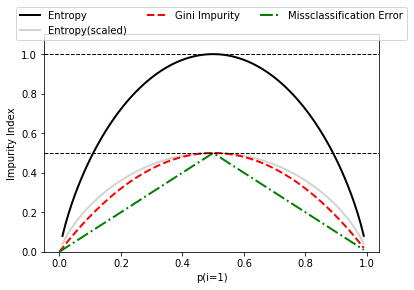

In [7]:
def gini(p):
    return (p)*(1-(p)) + (1-p)*(1-(1-p))

def entropy(p):
    return -p*np.log2(p) - (1-p)*np.log2((1-p))

def error(p):
    return 1-np.max([p, 1-p])

x = np.arange(0.0, 1.0, 0.01)
ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e*0.5 if e else None for e in ent]
err = [error(i) for i in x]
fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c in zip([ent, sc_ent, gini(x), err], 
                         ['Entropy', 'Entropy(scaled)', 'Gini Impurity', 'Missclassification Error'], 
                         ['-', '-', '--', '-.'],
                        ['black', 'lightgray', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=True, shadow=False)
ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity Index')
plt.show()

### Building a Decision Tree

Decision trees can build complex decision boundaries by dividing the feature space into rectangles. However, we have to be careful since the deeper the decision tree, the more complex the decision boundary becomes, which can easily result in over tting. Using scikit-learn, we will now train a decision tree with a maximum depth of 3 using entropy as a criterion for impurity. Although feature scaling may be desired for visualization purposes, note that feature scaling is not a requirement for decision tree algorithms. The code is as follows:

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

In [11]:
iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0
)

In [15]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

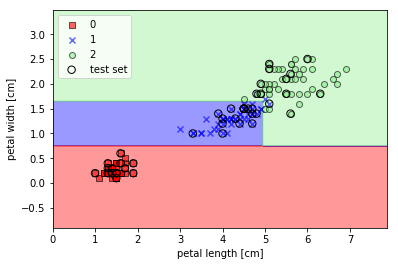

In [17]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
tree.fit(X_train, y_train)
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, classifier=tree, test_idx=range(105, 150))
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.show()

#### plot_decision_regions

In [16]:
def versiontuple(v):
    return tuple(map(int, (v.split("."))))


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

    # highlight test samples
    if test_idx:
        # plot all samples
        if not versiontuple(np.__version__) >= versiontuple('1.9.0'):
            X_test, y_test = X[list(test_idx), :], y[list(test_idx)]
            warnings.warn('Please update to NumPy 1.9.0 or newer')
        else:
            X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    alpha=1.0,
                    edgecolor='black',
                    linewidths=1,
                    marker='o',
                    s=55, label='test set')

### Combining weak to strong learners via random forests

In [18]:
from sklearn.ensemble import RandomForestClassifier

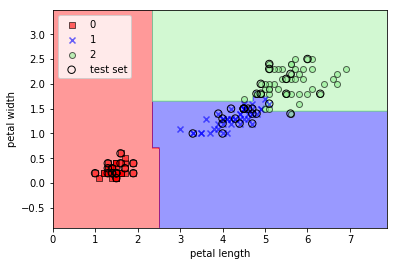

In [19]:
forest = RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=1, n_jobs=2)
forest.fit(X_train, y_train)
plot_decision_regions(X_combined, y_combined, classifier=forest, test_idx=range(105, 150))
plt.xlabel('petal length')
plt.ylabel('petal width')
plt.legend(loc='upper left')
plt.show()